In [139]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

#!pip install linearmodels
#!pip3 install statsmodels
from linearmodels.panel import PanelOLS
from statsmodels.api import add_constant


import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan

from linearmodels.panel import RandomEffects

from sklearn.cluster import KMeans

np.random.seed(123)


In [140]:
equ = pd.read_csv("C:/Users/User/Desktop/Python/In_progress/russia_losses_equipment.csv")
per = pd.read_csv("C:/Users/User/Desktop/Python/In_progress/russia_losses_personnel.csv")

These are the datasets that describe Equipment Losses & Death Toll & Military Wounded & Prisoner of War of russians in 2022 Ukraine russia War. It is a time-series data from February 24th till nowadays which shows Russian losses as military equipment and as casualties (2 datasets). These datasets can be used perfectly for data manipulation and visualization. Data was taken from  Kaggle: “2022 Russia Ukraine War”( https://www.kaggle.com/datasets/piterfm/2022-ukraine-russian-war)

Tracking : 
* Personnel
* Prisoner of War (POW) - - has not been tracked since 2022-04-28
* Aircraft
* Helicopter
* Tank
* Armored Personnel Carrier (APC)
* Multiple Rocket Launcher (MRL)
* Field Artillery
* Military Auto - has not been tracked since 2022-05-01; joined with Fuel Tank into Vehicles and Fuel Tanks
* Fuel Tank - has not been tracked since 2022-05-01; joined with Military Auto into Vehicles and Fuel Tanks
* Anti-aircraft warfare
* Drone - UAV+RPA
* Naval Ship - Warships, Boats
* Anti-aircraft Warfare
* Mobile SRBM System - has not been tracked since 2022-05-01; joined into Cruise Missiles
* Vehicles and Fuel Tanks - appear since 2022-05-01 as a sum of Fuel Tank and Military Auto
* Cruise Missiles - appear since 2022-05-01
* Direction of Greatest Losses - appear since 2022-04-25 

# Checking data and data manipulation

In [141]:
equ.head()

,date,day,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system,greatest losses direction,vehicles and fuel tanks,cruise missiles
0,2022-02-25,2,10,7,80,516,49,4,100.0,60.0,0,2,0,NaN,NaN,NaN,NaN,NaN
1,2022-02-26,3,27,26,146,706,49,4,130.0,60.0,2,2,0,NaN,NaN,NaN,NaN,NaN
2,2022-02-27,4,27,26,150,706,50,4,130.0,60.0,2,2,0,NaN,NaN,NaN,NaN,NaN
3,2022-02-28,5,29,29,150,816,74,21,291.0,60.0,3,2,5,NaN,NaN,NaN,NaN,NaN
4,2022-03-01,6,29,29,198,846,77,24,305.0,60.0,3,2,7,NaN,NaN,NaN,NaN,NaN


In [142]:
per.head()

,date,day,personnel,personnel*,POW
0,2022-02-25,2,2800,about,0.0
1,2022-02-26,3,4300,about,0.0
2,2022-02-27,4,4500,about,0.0
3,2022-02-28,5,5300,about,0.0
4,2022-03-01,6,5710,about,200.0


In [143]:
equ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402 entries, 0 to 401
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       402 non-null    object 
 1   day                        402 non-null    int64  
 2   aircraft                   402 non-null    int64  
 3   helicopter                 402 non-null    int64  
 4   tank                       402 non-null    int64  
 5   APC                        402 non-null    int64  
 6   field artillery            402 non-null    int64  
 7   MRL                        402 non-null    int64  
 8   military auto              65 non-null     float64
 9   fuel tank                  65 non-null     float64
 10  drone                      402 non-null    int64  
 11  naval ship                 402 non-null    int64  
 12  anti-aircraft warfare      402 non-null    int64  
 13  special equipment          383 non-null    float64

In [144]:
per.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402 entries, 0 to 401
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        402 non-null    object 
 1   day         402 non-null    int64  
 2   personnel   402 non-null    int64  
 3   personnel*  402 non-null    object 
 4   POW         62 non-null     float64
dtypes: float64(1), int64(2), object(2)
memory usage: 15.8+ KB


#### To better manipulate and visualize data, we change the variable "date" in both datasets from object to datetime.

In [145]:
equ["date"] = pd.to_datetime(equ["date"])
equ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402 entries, 0 to 401
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       402 non-null    datetime64[ns]
 1   day                        402 non-null    int64         
 2   aircraft                   402 non-null    int64         
 3   helicopter                 402 non-null    int64         
 4   tank                       402 non-null    int64         
 5   APC                        402 non-null    int64         
 6   field artillery            402 non-null    int64         
 7   MRL                        402 non-null    int64         
 8   military auto              65 non-null     float64       
 9   fuel tank                  65 non-null     float64       
 10  drone                      402 non-null    int64         
 11  naval ship                 402 non-null    int64         
 12  anti-air

In [146]:
per["date"] = pd.to_datetime(per["date"])
per.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402 entries, 0 to 401
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        402 non-null    datetime64[ns]
 1   day         402 non-null    int64         
 2   personnel   402 non-null    int64         
 3   personnel*  402 non-null    object        
 4   POW         62 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 15.8+ KB


#### Cheking missing values.

In [147]:
equ.isna().sum()

date                           0
day                            0
aircraft                       0
helicopter                     0
tank                           0
APC                            0
field artillery                0
MRL                            0
military auto                337
fuel tank                    337
drone                          0
naval ship                     0
anti-aircraft warfare          0
special equipment             19
mobile SRBM system           366
greatest losses direction    199
vehicles and fuel tanks       65
cruise missiles               65
dtype: int64

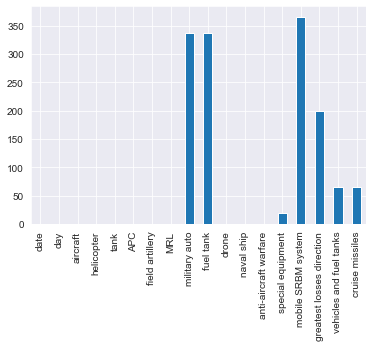

In [148]:
equ.isna().sum().plot(kind = "bar")
plt.show()

In [149]:
per.isna().sum()

date            0
day             0
personnel       0
personnel*      0
POW           340
dtype: int64

#### In a dataset "personnel" we can delete the varible POW (Prisoner of War) as has not been tracked since 2022-04-28 and in a dataset "equipment" we can drop missing values (5 % or less of total value). 

In [150]:
per.drop('POW',axis=1,inplace=True)

In [151]:
per

,date,day,personnel,personnel*
0,2022-02-25,2,2800,about
1,2022-02-26,3,4300,about
2,2022-02-27,4,4500,about
3,2022-02-28,5,5300,about
4,2022-03-01,6,5710,about
...,...,...,...,...
397,2023-03-29,399,172340,about
398,2023-03-30,400,172900,about
399,2023-03-31,401,173360,about
400,2023-04-01,402,173990,about


In [152]:
threshold = len(equ) * 0.05
cells_to_drop = equ.columns[equ.isna().sum() <= threshold]
print(cells_to_drop)

Index(['date', 'day', 'aircraft', 'helicopter', 'tank', 'APC',
       'field artillery', 'MRL', 'drone', 'naval ship',
       'anti-aircraft warfare', 'special equipment'],
      dtype='object')


In [153]:
equ.dropna(subset = cells_to_drop, inplace = True)

In [154]:
equ.isnull().sum() 

date                           0
day                            0
aircraft                       0
helicopter                     0
tank                           0
APC                            0
field artillery                0
MRL                            0
military auto                337
fuel tank                    337
drone                          0
naval ship                     0
anti-aircraft warfare          0
special equipment              0
mobile SRBM system           347
greatest losses direction    180
vehicles and fuel tanks       46
cruise missiles               46
dtype: int64

In [155]:
 # equ.fillna(method = "ffill")  trying not dropping but replace by last valid observation

#### As a result, we dropped a column "POW" and do not have missing values in a varible "special equipment" and get less missing values in 4 other columns.

In [156]:
equ.describe()

,day,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system,vehicles and fuel tanks,cruise missiles
count,383.00000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,46.000000,46.000000,383.000000,383.000000,383.000000,383.000000,36.000000,337.000000,337.000000
mean,212.00000,243.621410,221.182768,2216.556136,4676.624021,1378.600522,318.655352,1308.847826,73.173913,1118.519582,14.480418,160.686684,124.357702,3.944444,3833.178042,424.317507
std,110.70682,50.212014,52.078103,909.400580,1569.358396,726.008769,122.408407,243.455309,5.396725,668.461870,3.425957,65.826569,73.621431,0.333333,1092.338336,290.321205
min,21.00000,84.000000,108.000000,430.000000,1375.000000,190.000000,70.000000,819.000000,60.000000,11.000000,3.000000,43.000000,10.000000,2.000000,1796.000000,84.000000
25%,116.50000,216.000000,181.000000,1472.500000,3582.500000,747.000000,236.500000,1145.500000,73.000000,599.500000,14.000000,98.000000,55.000000,4.000000,2823.000000,170.000000
50%,212.00000,254.000000,219.000000,2254.000000,4796.000000,1355.000000,326.000000,1359.500000,76.000000,950.000000,15.000000,170.000000,126.000000,4.000000,3959.000000,316.000000
75%,307.50000,283.000000,267.000000,3016.500000,6030.500000,1998.500000,418.000000,1493.000000,76.000000,1707.000000,16.000000,212.000000,179.000000,4.000000,4801.000000,723.000000
max,403.00000,306.000000,291.000000,3618.000000,6986.000000,2687.000000,527.000000,1701.000000,76.000000,2249.000000,18.000000,279.000000,296.000000,4.000000,5537.000000,911.000000


In [157]:
per.describe()

,day,personnel
count,402.000000,402.000000
mean,202.500000,68174.007463
std,116.191652,46552.912099
min,2.000000,2800.000000
25%,102.250000,31175.000000
50%,202.500000,53475.000000
75%,302.750000,100812.500000
max,403.000000,174550.000000


# Data visualization

#### Visualization for "personnel" dataset

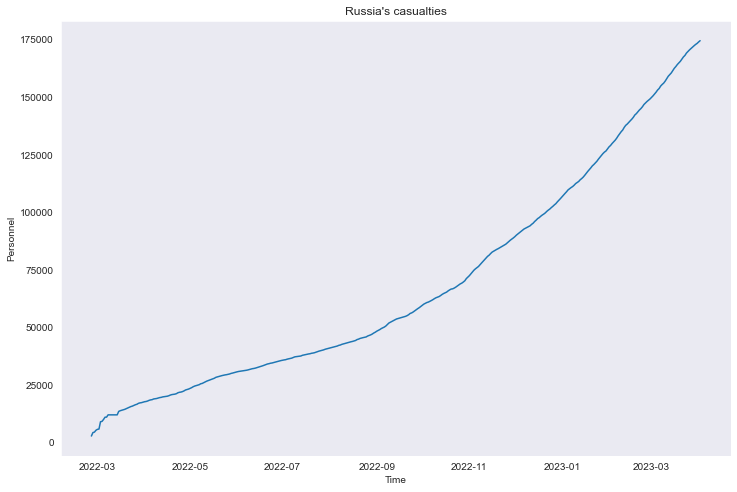

In [158]:
plt.figure(figsize=(12, 8))
sns.set_style("dark")
ax = sns.lineplot(x = "date", y = "personnel", data = per)
ax.set(xlabel = "Time", ylabel = "Personnel",title = "Russia's casualties")
plt.show()

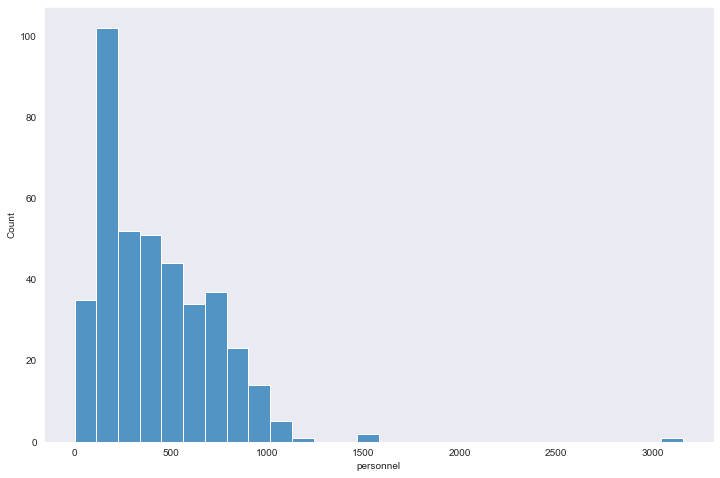

In [159]:
plt.figure(figsize=(12, 8))
sns.histplot(per["personnel"].diff()) # count casualties 
plt.show()

#### Visualization for "Equipment" dataset

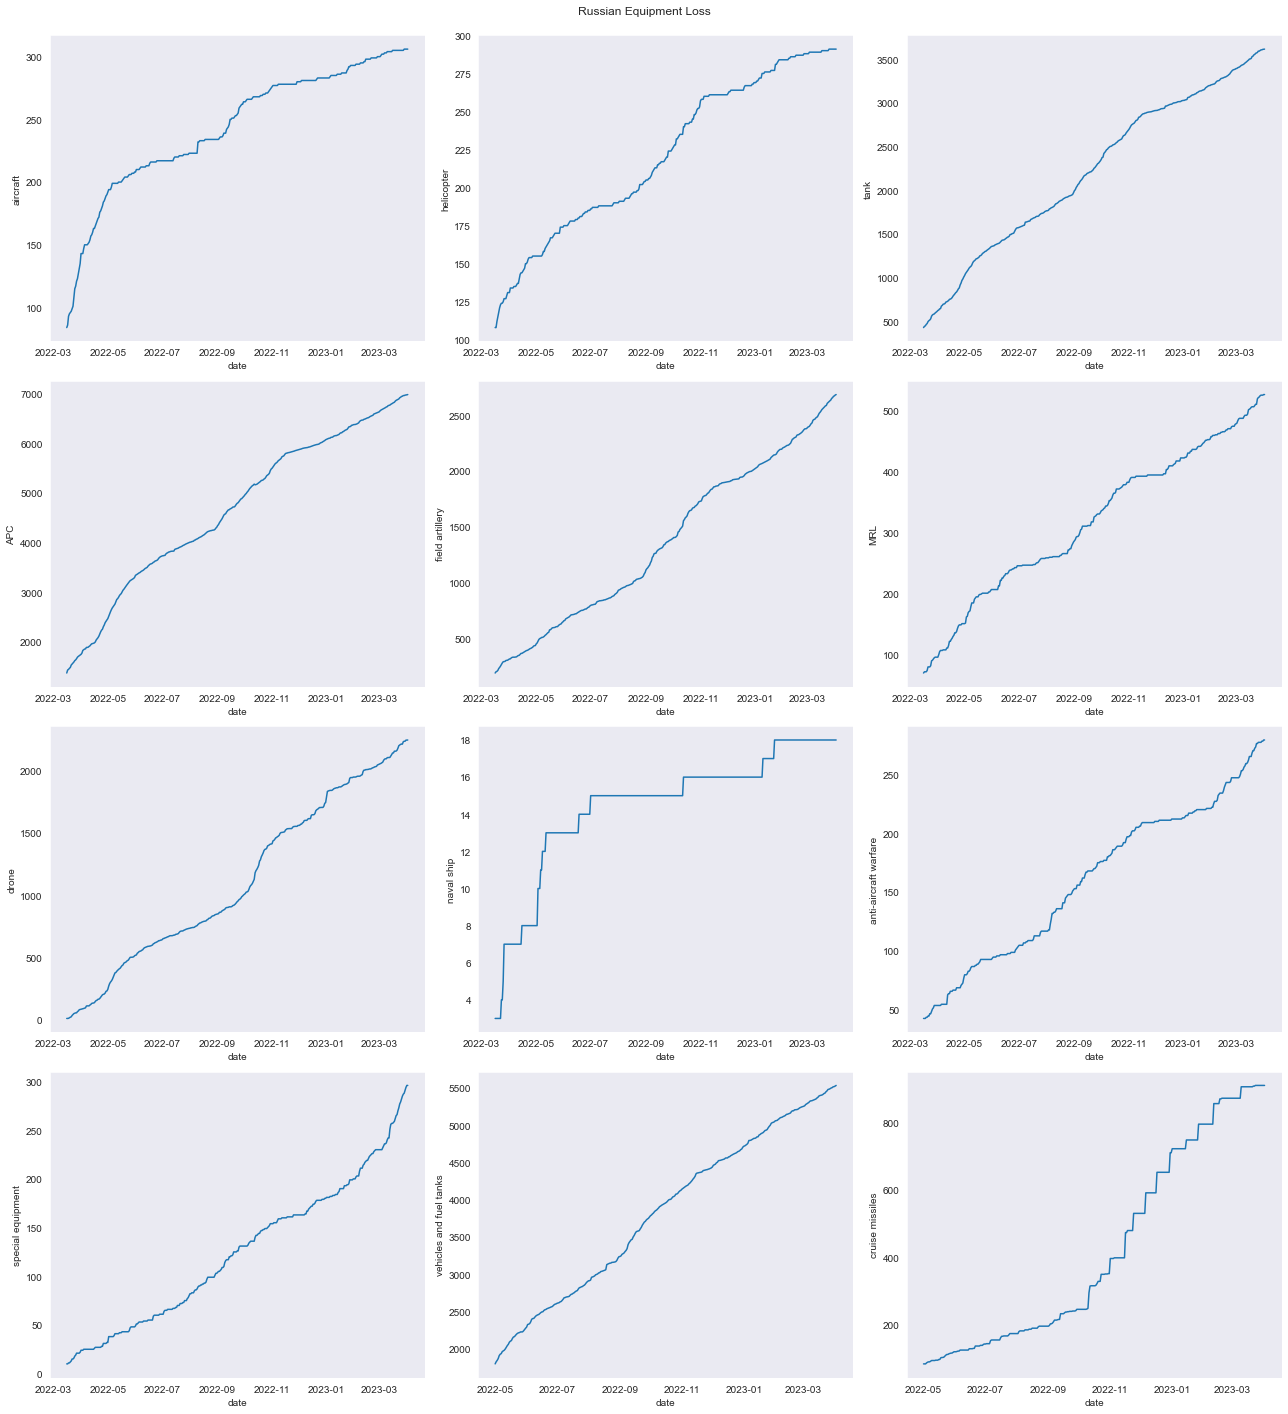

In [160]:
fig, ax = plt.subplots(4, 3, figsize=(18, 20))
sns.lineplot(ax=ax[0, 0], data=equ, x='date', y='aircraft')
sns.lineplot(ax=ax[0, 1], data=equ, x='date', y='helicopter')
sns.lineplot(ax=ax[0, 2], data=equ, x='date', y='tank')
sns.lineplot(ax=ax[1, 0], data=equ, x='date', y='APC')
sns.lineplot(ax=ax[1, 1], data=equ, x='date', y='field artillery')
sns.lineplot(ax=ax[1, 2], data=equ, x='date', y='MRL')
sns.lineplot(ax=ax[2, 0], data=equ, x='date', y='drone')
sns.lineplot(ax=ax[2, 1], data=equ, x='date', y='naval ship')
sns.lineplot(ax=ax[2, 2], data=equ, x='date', y='anti-aircraft warfare')
sns.lineplot(ax=ax[3, 0], data=equ, x='date', y='special equipment')
sns.lineplot(ax=ax[3, 1], data=equ, x='date', y='vehicles and fuel tanks')
sns.lineplot(ax=ax[3, 2], data=equ, x='date', y='cruise missiles')
fig.suptitle("Russian Equipment Loss")
fig.tight_layout()
fig.subplots_adjust(top=0.96)

# External Military Aid in Ukraine


# Exploratory data analysis(for our own dataset)

In [161]:
aid = pd.read_csv("C:/Users/User/Desktop/Python/In_progress/aid.csv")

 The dataset provided contains information on various aspects of the Russian invasion of Ukraine, including casualties, territory captured by the Russian army, and military aid. We decided to separate the aid, ID 1 is the American aid and the ID 2 is what we call NATO, it is the 9 countries that send the most aid to Ukraine in dollars term. These 9 countries are Canada, the Czech Republic, Denmark, France, Germany, Norway, Poland, Sweden, and the United Kingdom. The dataset contains 44 observations for each ID so in total 88 observations and 8 variables: 
 * "week": The week number starting from 0
 * "ID": Origin of the aid, 1= United States of America, 2= Our group of 9 countries
 * "casulties_week": Number of Russian casualties that occurred in a given week.
 * "casulties_cumulative": Cumulative total of Russian casualties.
 * "territory_week_miles": Number of square miles captured by the Russian army in a given week.
 * "territory_cumulative_miles": Cumulative total of square miles captured by the Russian army.
 * "aid_week": Amount of American and 9 countries military aid given to Ukraine in millions of dollars in a given week.
 * "aid_cumulative": Cumulative total of American and 9 countries military aid given to Ukraine in millions of dollars.
 
The data is presented in a weekly granularity, with the first day of the invasion considered as week 0. The data is in .csv format and covers the period from 24 February to 31 December. The data is sourced from the Ukraine MOD (“Ministry of Defence of Ukraine”), US MOD (“Releases, U.S. Department of Defense”), the Washington Post (Ledger), and the Kiel Institute (Trebesch et al.). The data from the Ukraine MOD, and US MOD were originally in daily format but transformed to be weekly. The second incomplete data was from the Washington post where the
3
data ended on November 17 but was completed with the open-source resource (war_mapper). Thirdly the data from the Kiel Institute, the data were daily, so it needed to be transformed to be weekly and it was missing the last 4 weeks, where we decided to use the average.

In [162]:
aid.head()

,week,ID,casulties_week,casulties_cumulative,territory_week_miles,territory_cumulative_miles,aid_week,aid_cumulative
0,0,1,1000,1000,13721,13721,0.0,0.0
1,1,1,8000,9000,16326,30047,350.0,350.0
2,2,1,3000,12000,579,30626,0.0,350.0
3,3,1,2000,14000,-90,30536,1000.0,1350.0
4,4,1,1800,15800,3812,34348,0.0,1350.0


In [163]:
aid.info()
aid.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   week                        90 non-null     int64  
 1   ID                          90 non-null     int64  
 2   casulties_week              90 non-null     int64  
 3   casulties_cumulative        90 non-null     int64  
 4   territory_week_miles        90 non-null     int64  
 5   territory_cumulative_miles  90 non-null     int64  
 6   aid_week                    90 non-null     float64
 7   aid_cumulative              90 non-null     float64
dtypes: float64(2), int64(6)
memory usage: 5.8 KB


week                          0
ID                            0
casulties_week                0
casulties_cumulative          0
territory_week_miles          0
territory_cumulative_miles    0
aid_week                      0
aid_cumulative                0
dtype: int64

In [164]:
aid["ID"].value_counts()

1    45
2    45
Name: ID, dtype: int64

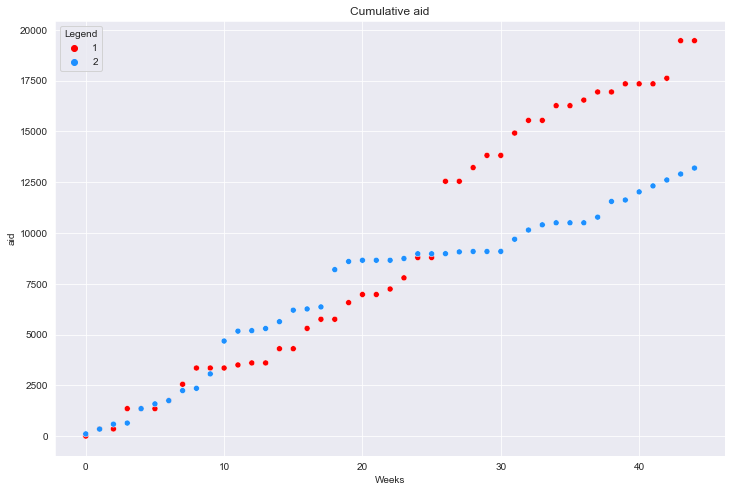

In [165]:
plt.figure(figsize=(12, 8))
sns.set_style("darkgrid")
color_dict = ({1 : "red", 2 : "dodgerblue"})
ax = sns.scatterplot(x = "week", y = "aid_cumulative",data = aid, palette= color_dict, hue = "ID", hue_order = [1,2])
ax.set(xlabel = "Weeks", ylabel = "aid",title = "Cumulative aid")
plt.legend(title = "Legend")
plt.show()

#### From this graph it is noticeable how the help from the US is more than from 9 countries of Europe. There was a rapid increase at US help after 25th week.

#### The following step is to convert square miles to square kilometers and get two more variables which we are going to use.

In [166]:
aid["territory_cumulative_km"] = aid["territory_cumulative_miles"] * 2.59
aid["territory_week_km "] = aid["territory_week_miles"] * 2.59
aid.head()

,week,ID,casulties_week,casulties_cumulative,territory_week_miles,territory_cumulative_miles,aid_week,aid_cumulative,territory_cumulative_km,territory_week_km
0,0,1,1000,1000,13721,13721,0.0,0.0,35537.39,35537.39
1,1,1,8000,9000,16326,30047,350.0,350.0,77821.73,42284.34
2,2,1,3000,12000,579,30626,0.0,350.0,79321.34,1499.61
3,3,1,2000,14000,-90,30536,1000.0,1350.0,79088.24,-233.10
4,4,1,1800,15800,3812,34348,0.0,1350.0,88961.32,9873.08


#### There is a significant remark that Russia captured almost all territories during the first 7 weeks, and there was not much external help in the first 7 weeks. Therefore, it can influence our results and inferences from the tests. That’s why we decided to drop the first 7 weeks.

In [167]:
short_data = aid.drop([0,1,2,3,4,5,6,7,45,46,47,48,49,50,51,52])
short_data

,week,ID,casulties_week,casulties_cumulative,territory_week_miles,territory_cumulative_miles,aid_week,aid_cumulative,territory_cumulative_km,territory_week_km
8,8,1,1100,21000,1354,25607,800.000000,3350.00000,66322.13,3506.86
9,9,1,1800,22800,1701,27308,0.000000,3350.00000,70727.72,4405.59
10,10,1,1900,24700,-488,26820,0.000000,3350.00000,69463.80,-1263.92
11,11,1,1950,26650,815,27635,150.000000,3500.00000,71574.65,2110.85
12,12,1,1850,28500,-41,27594,100.000000,3600.00000,71468.46,-106.19
...,...,...,...,...,...,...,...,...,...,...
85,40,2,3720,89440,4,23543,400.000000,12024.15356,60976.37,10.36
86,41,2,3640,93080,-1,23542,293.272038,12317.42560,60973.78,-2.59
87,42,2,3510,96590,3,23545,293.272038,12610.69764,60981.55,7.77
88,43,2,3810,100400,-1,23544,293.272038,12903.96968,60978.96,-2.59


#### Create two separate datasets for each ID.

In [168]:
us = short_data[short_data["ID"] == 1]
nato = short_data[short_data["ID"] == 2]
us.head()

,week,ID,casulties_week,casulties_cumulative,territory_week_miles,territory_cumulative_miles,aid_week,aid_cumulative,territory_cumulative_km,territory_week_km
8,8,1,1100,21000,1354,25607,800.0,3350.0,66322.13,3506.86
9,9,1,1800,22800,1701,27308,0.0,3350.0,70727.72,4405.59
10,10,1,1900,24700,-488,26820,0.0,3350.0,69463.80,-1263.92
11,11,1,1950,26650,815,27635,150.0,3500.0,71574.65,2110.85
12,12,1,1850,28500,-41,27594,100.0,3600.0,71468.46,-106.19


In [169]:
nato.head()

,week,ID,casulties_week,casulties_cumulative,territory_week_miles,territory_cumulative_miles,aid_week,aid_cumulative,territory_cumulative_km,territory_week_km
53,8,2,1100,21000,1354,25607,111.235545,2349.469121,66322.13,3506.86
54,9,2,1800,22800,1701,27308,710.608422,3060.077543,70727.72,4405.59
55,10,2,1900,24700,-488,26820,1618.461701,4678.539244,69463.80,-1263.92
56,11,2,1950,26650,815,27635,487.500000,5166.039244,71574.65,2110.85
57,12,2,1850,28500,-41,27594,25.096000,5191.135244,71468.46,-106.19


#### For future analysis we will be using 3 datasets.For each of them we create indexes to manipulate as a panel data and use appropriate tests. A Column "ID" is our field of interests(heterogeneity) and a column "week" is a time-series data. 

In [170]:
us = us.set_index(["ID", "week"])
nato = nato.set_index(["ID", "week"])
df = short_data.set_index(["ID", "week"])
df.head()

casulties_week  casulties_cumulative  territory_week_miles  \
ID week                                                               
1  8               1100                 21000                  1354   
   9               1800                 22800                  1701   
   10              1900                 24700                  -488   
   11              1950                 26650                   815   
   12              1850                 28500                   -41   

         territory_cumulative_miles  aid_week  aid_cumulative  \
ID week                                                         
1  8                          25607     800.0          3350.0   
   9                          27308       0.0          3350.0   
   10                         26820       0.0          3350.0   
   11                         27635     150.0          3500.0   
   12                         27594     100.0          3600.0   

         territory_cumulative_km  territory_week_km   
ID week                                               
1  8                    66322.13             3506.86  
   9                    70727.72             4405.59  
   10                   69463.80            -1263.92  
   11                   71574.65             2110.85  
   12                   71468.46             -106.19

## Pooled regressions

#### 1. As land (territory) is a valuable economic resource we have one of the most important tests with territory and aid. It is a liberated territory from the occupation that depends on the US and NATO military aid to Ukraine.

#### Before carrying out tests, let’s check out the assumptions:

#### For pooling OLS, we have conducted Breusch–Godfrey test (test for autocorrelation) and Breusch–Pagan test (test for homoskedasticity).

In [171]:
y = df["territory_cumulative_km"]
x = add_constant(df["aid_cumulative"])
pool = sm.OLS(y, x, entity_effects=False, time_effects=False).fit()
bg_test = acorr_breusch_godfrey(pool, nlags=1)
print(bg_test)

(58.58948687534292, 1.9425167375235543e-14, 269.93608418486156, 6.818947606140288e-26)


d:\anaconda3\lib\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['entity_effects', 'time_effects']
  warnings.warn(msg, ValueWarning)


#### Breusch-Godfrey test shows if we have in our model autocorrelation. The test showed that we reject the null hypothesis(P≤0,05), therefore we accept autocorrelation(in our case p-value = 1.9425167375235543e-14).

In [172]:
pool =smf.ols('territory_cumulative_km ~ aid_cumulative', data=df).fit()
bp_test = het_breuschpagan(pool.resid, pool.model.exog)
print(bp_test)

(0.025502762212625596, 0.8731206758271741, 0.024822052840813926, 0.8752522853312223)


#### Breusch-Pagan test shows that we accept the null hypothesis(P>0,05) and hence have homoskedasticity(in our case p-value = 0.8731206758271741).

#### To avoid the problem with autocorrelation we decided to use clustered covariance.

In [173]:
y = df["territory_cumulative_km"]
x = add_constant(df["aid_cumulative"])
pool = PanelOLS(y, x, entity_effects=False, time_effects=False)
print(pool.fit(cov_type = "clustered").summary)

                             PanelOLS Estimation Summary                             
Dep. Variable:     territory_cumulative_km   R-squared:                        0.3881
Estimator:                        PanelOLS   R-squared (Between):              0.0000
No. Observations:                       74   R-squared (Within):               0.4099
Date:                     Thu, May 25 2023   R-squared (Overall):              0.3881
Time:                             18:13:21   Log-likelihood                   -724.76
Cov. Estimator:                  Clustered                                           
                                             F-statistic:                      45.672
Entities:                                2   P-value                           0.0000
Avg Obs:                            37.000   Distribution:                    F(1,72)
Min Obs:                            37.000                                           
Max Obs:                            37.000   F-statist

#### The coefficient has a negative value (inverse relationship) and it can be interpreted as for each one million American dollars, Ukraine gains back 766 square meters (coefficient), and from the p-value from T-statistic and F- statistics we reject the null hypothesis, and hence there is a relationship between the whole aid and the liberated territory. From R- squared we can notice 39 percent which is the independent variable (the whole aid) explaining the dependent variable (liberated territory).

#### 2. The second test we have done was liberated territory from the occupation that depends only on NATO military aid to Ukraine.

In [174]:
y = nato["territory_cumulative_km"]
x = add_constant(nato["aid_cumulative"])
pool = PanelOLS(y, x, entity_effects=False, time_effects=False)
print(pool.fit(cov_type = "clustered").summary)

                             PanelOLS Estimation Summary                             
Dep. Variable:     territory_cumulative_km   R-squared:                        0.3282
Estimator:                        PanelOLS   R-squared (Between):              0.0000
No. Observations:                       37   R-squared (Within):               0.3282
Date:                     Thu, May 25 2023   R-squared (Overall):              0.3282
Time:                             18:13:21   Log-likelihood                   -364.11
Cov. Estimator:                  Clustered                                           
                                             F-statistic:                      17.099
Entities:                                1   P-value                           0.0002
Avg Obs:                            37.000   Distribution:                    F(1,35)
Min Obs:                            37.000                                           
Max Obs:                            37.000   F-statist

#### We can notice one particularly important and very crucial detail in our model. The coefficient is smaller(-1.1830 in contrast to the previous test coefficient -0.7666 where we tested NATO and the US aid together), but how is it possible to have a smaller value just with NATO aid?
#### The answer is quite simple. NATO sent less aid but more dangerous military aid which helps to take back Ukrainian territory. At the same time, the US sent much more and we will test it in the next regression model. The coefficient means that with 1 million dollars from NATO Ukraine takes back more than 1 square kilometer. The statistical result from the test: T-statistics and F-statistics show that there is a relationship between these two variables, standard error is small in comparison to the coefficient. A bit worse result is R-squared which is 33 percent.
#### One remarkable notice is that it is fine to have not so big, R-squared because the liberated territory doesn’t depend on only military aid. But in our theoretical model, we did not include more variables. It is a matter of data that is problematic to find right now.

#### 3. The third test we have done was liberated territory from the occupation that depends only on US military aid to Ukraine.

In [175]:
y = us["territory_cumulative_km"]
x = add_constant(us["aid_cumulative"])
pool = PanelOLS(y, x, entity_effects=False, time_effects=False)
print(pool.fit(cov_type = "clustered").summary)

                             PanelOLS Estimation Summary                             
Dep. Variable:     territory_cumulative_km   R-squared:                        0.5340
Estimator:                        PanelOLS   R-squared (Between):              0.0000
No. Observations:                       37   R-squared (Within):               0.5340
Date:                     Thu, May 25 2023   R-squared (Overall):              0.5340
Time:                             18:13:21   Log-likelihood                   -357.34
Cov. Estimator:                  Clustered                                           
                                             F-statistic:                      40.108
Entities:                                1   P-value                           0.0000
Avg Obs:                            37.000   Distribution:                    F(1,35)
Min Obs:                            37.000                                           
Max Obs:                            37.000   F-statist

#### In this model, we have proved our theory which we got in the previous test. The coefficient of the US influences so much coefficient of the US and NATO. Because the coefficient from both is -0.766 and from the US is -0.7263.
#### There is a relationship between the regressor variable and dependent variable, a pretty small standard error. In this case, the R-squared is much better- 53 % is explained by the independent variable.
#### As a conclusion, the US sent much more than NATO but it does not help much to liberate the territory in contrast to NATO aid and NATO sent much less but it was more helpful.


#### 4. Russian soldiers’ casualties on Ukrainian-occupied territory. Because territory cannot be occupied without soldiers.

In [176]:
y = df["casulties_cumulative"]
x = add_constant(df["aid_cumulative"])
pool = PanelOLS(y, x, entity_effects=False, time_effects=False)
print(pool.fit().summary)

                           PanelOLS Estimation Summary                            
Dep. Variable:     casulties_cumulative   R-squared:                        0.7375
Estimator:                     PanelOLS   R-squared (Between):              0.0000
No. Observations:                    74   R-squared (Within):               0.7790
Date:                  Thu, May 25 2023   R-squared (Overall):              0.7375
Time:                          18:13:22   Log-likelihood                   -801.83
Cov. Estimator:              Unadjusted                                           
                                          F-statistic:                      202.31
Entities:                             2   P-value                           0.0000
Avg Obs:                         37.000   Distribution:                    F(1,72)
Min Obs:                         37.000                                           
Max Obs:                         37.000   F-statistic (robust):             202.31
    

#### In this model, we have a positive coefficient (positive distribution), which means that for every 1 million US and NATO aid there are 4 Russian casualties. There is a relationship between independent and dependent variables. Seventy-four percent is explained by regressors and the small standard error which is good.

# Fixed effects

In [177]:
y = df["territory_cumulative_km"]
x = add_constant(df["aid_cumulative"])
within = PanelOLS(y, x, entity_effects=True, time_effects=False).fit(cov_type = "clustered")
print(within.summary)

                             PanelOLS Estimation Summary                             
Dep. Variable:     territory_cumulative_km   R-squared:                        0.4112
Estimator:                        PanelOLS   R-squared (Between):              0.0000
No. Observations:                       74   R-squared (Within):               0.4112
Date:                     Thu, May 25 2023   R-squared (Overall):              0.3868
Time:                             18:13:22   Log-likelihood                   -723.34
Cov. Estimator:                  Clustered                                           
                                             F-statistic:                      49.594
Entities:                                2   P-value                           0.0000
Avg Obs:                            37.000   Distribution:                    F(1,71)
Min Obs:                            37.000                                           
Max Obs:                            37.000   F-statist

#### To get fixed effects we change entity_effects=True. It is noticeable that there is no significant difference between pooled model and the fixed effects model. In the case of fixed effects, we still reject the null hypothesis and there is a relationship between independent and dependent variables. Coefficients became better and the explanation of the model increased to 41 percent by 2 percent in contrast to the pooling model. 
#### By F test we compare pooled OLS and fixed effects. In our case, we do not reject the null hypothesis because P > 0,05 so pooled LS is an efficient and consistent estimator. But there is some evidence of individual effects having an impact on the dependent variable.

# Random effects

In [178]:
#y = df['territory_cumulative_km']
#x = add_constant(df["aid_cumulative"])
#rand = RandomEffects(y, x)
#randf = rand.fit(cov_type='clustered')
#print(randf.summary)

#### If we include an intercept we get an error “ZeroDivisionError: float division by zero”. This error may occur if there are not enough groups or time periods in the data, causing the model to not be identified. If the number of groups or time periods is very small, this causes the error. In this case, we need to consider a different model.

#### To sum up, we should use pooled OLS here. Thus, there are no significant differences between the objects of the sample(heterogeneity).

### As a conclusion, we estimated how the US and nine significant countries of NATO help Ukraine with military aid and how Ukraine liberates its territories with this aid. This concept was built on two different dependent variables (territory, casualties). And all the models tested the most important dependent variable such as a territory. The results were quite unexpected because aid from the US and NATO differ. The US gives more in numbers, but it does not help much to liberate territory in comparison to NATO aid.
### There is no heterogeneity in data and pooled regression is consistent and efficient in this case. But Fixed effects and Random effects were tested as well. Unfortunately, we did not find a strong significant correlation to assume about the prediction about the ending of the war. It should be included many more different variables such as economical aid, humanitarian aid, voluntary aid… There might be different measurements for further analysis as well.